# Wealth Distribution


## Agent Based Models
While in graduate school I took one of the most fascinating courses I've taken: agent-based models. In short, it's a model where there are $N$ "agents" with some  value(s) of interest that changes based on some "simple" rules (typically based on its neighbors). The whole point of this is to study emergent behaviours from simple rules in a (large) population. One example is a model of birds where the values of interest are position and velocity. The rule could be something like the birds changing their velocity based on the average velocity of other birds within some distance from itself. This model, under certain circumstances, actually leads to the birds flocking. Being in the math department, it wasn't focused too much on the simulation aspects of it, but on the mathematical techniques to analyze these types of systems. We looked at classes of systems based on types of rules, but there was one system in particular had really caught me off guard.

## Binary Interaction
The binary interaction model is a system where there are $N$ agents and at each time step, we choose two agents randomly and have them interact. The code below can run any of these such simulations. Although it is very simple, it can represent many systems and lead to some interesting results.

In [1]:
from typing import Callable, List, Tuple, Union
from random import sample


Individual = Union[float, int]
Population = List[Individual]

def simulate(initial: Population, time: int, interaction: Callable) -> Population:
    n = len(initial)
    interactions = map(lambda _: sample(range(n), 2), range(time))

    output = initial.copy()
    for i, j in interactions:
        output[i], output[j] = interaction(output[i], output[j])

    return output

The systems we looked at were all economic models of sorts, essentially two agents interact by one giving the other some amount of money. We are interested in the long-term behavior of such systems. To make the system fair, all of our systems start the agents with the same amount of money.

In [2]:
x0, N, t = 5, 1_000, 10_000_000
initial_population = [x0 for _ in range(N)]

Simulations are fun and interesting, but formalizing a system, so we can use math to compute things gives much more confidence than a statistical analysis. I show the main ideas used to derive the formulas for the distributions below. After that, we explore three different interaction rules by showing the formulas, running a simulation, and plotting the distribution of the simulation. I won't derive the formula for each one, as it's very involved, but I can share the details, if interested.

## Mathematical Techniques For Analysis

Let $N$ be the number of agents, $X_t \in \bf{R}^N$, and $X^i_t$ represents the value of agent $i$ at time $t$. Suppose agent $i$ and $j$ have been selected to interact at time $t+h$ their values will interact in the following way.


$$
X^i_{t + h} = F_1(X^i_t, X^j_t, h)
$$

$$
X^j_{t + h} = F_2(X^i_t, X^j_t, h)
$$

Our goal is to find the distribution, and that is done by getting a differential equation that this process satisfies. Then to find the distribution, we take a general expectation of a generic function, $\phi(x)$, with our distribution $W(x, t + h)$ for all agents at time $t + h$ and use properties of our system and probability theory.


$$
E[ \phi(x^{t+h}) ] = \int \phi(x) W(x, t + h) dx
$$

Partitioning by the possible combinations and using the [law of total expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation) we get that the expectation value is also equivalent to the

$$
E[\phi(x^{t+h})] = \sum_{i \neq j} \frac{1}{N(N-1)} E[\phi(x^{t+h}) | (i, j) \text{ are selected } ]
$$

We apply the law of total expectation again and partition over the values of $x$ to get the following result


$$

 \sum_{i \neq j} \frac{1}{N(N-1)} E[\phi(x^{t+h}) | (i, j) \text{ are selected } ] =  \sum_{i \neq j} \frac{1}{N(N-1)} \int W(x, t) E[\phi(x^{t+h}) | (i, j) \text{ are selected and } x^t = x ]dx

$$


Putting these together, we have

$$
\int \phi(x) W(x, t + h) dx = \sum_{i \neq j} \frac{1}{N(N-1)} \int W(x, t) E[\phi(x^{t+h}) | (i, j) \text{ are selected and } x^t = x ]dx
$$


This setup works for all binary interaction setups, but after that, we usually start to use properties of our rules to further expand the right-hand side. The typical techniques at this point would be to use [indicator functions](https://en.wikipedia.org/wiki/Indicator_function) for the conditionals of possible events.  Then try to shift the right-hand side, using taylor expansions, so that you can get matching inputs for test functions and distribution functions. The goal is to  get things that look like $\phi(x + \delta)  - \phi(x)$ and $W(x, t + h) - W(x, t)$ so that we can take limits and get derivatives. We also try to remove all derivatives of $\phi$ by doing integration by part. The overall goal is to massage the equation, so we get something that looks like this:

$$

\int \left[ \text{ some partial differential equation } \right] \phi(x) dx = 0

$$

And because $\phi(x)$ is any differentiable function, the PDE must be equal to zero. This then gives us a differential equation that this distribution satisfies. Usually we can't get a closed form solution for the equation, but it still allows us to look at long-term behavior and occasionally lets us compute the average and variance as a function of time. One thing to note here is that the $\delta$ used in our simulations is held as a constant, but is going towards zero in our mathematical analysis, so these techniques aren't necessarily an exact match to the simulations. Our simulations are more of an approximation to our mathematical model.

This may not be the most useful thing right now, so I will provide the full derivation of one these systems in another post.

## Fixed Transaction
I will start with the simplest model, the one we focused on in class, because I believe it has the most surprising results. The mathematical rules this system follow are the following:


$$
X^i_{t + h} = X^i_t + \delta
$$

$$
X^j_{t + h} = X^j_t - \delta
$$

if $X^j_{t} \geq \delta$, otherwise, no exchange is made and choose another pair of agents. $\delta$ is a fixed number that is held constant for the whole simulation. The same logic is coded up below.

In [3]:
def fixed_transaction(x1: Individual, x2: Individual) -> Tuple[Individual, Individual]:
    delta = 0.1
    if x2 >= delta:
        return x1 + delta, x2 - delta
    return x1, x2

After a really long derivation, like two and a half lectures, we end up with the following non-linear partial differential equation.

$$
\partial_t f - \frac{d}{N} f(0, t) \partial_x f + \frac{d}{N} \partial_{xx} f =  0
$$

Here,the distribution, $f$, is no longer the distribution of the populations, but the distribution for one of the agents which is randomly selected. $d$ is the limit of $\delta^2/h$ as both $\delta$ and $h$ approach zero. From this, we can compute the mean and the asymptotic distribution (limit of distribution as $t \to \infty$). Using this formula we find out that the mean is unsurprisingly constant and the asymptotic distribution is a bit surprising. The results are summarized below. Please stop and remember that this game is random as hell and everyone has the same chance of being selected, and they all have the same probability of losing $\delta$ or gaining $\delta$ dollars.

$$
f(x) = x_0 e^{-\frac{x}{x_0}}
$$

This system approaches an exponential distribution! This was quite an interesting result to me because the game is so random and "fair" that I thought it would lead to a normal distribution, but unfortunately that is not case. Below we run a simulation for a while and plot the distribution to confirm.

In [4]:
fixed_result = simulate(initial_population, t, fixed_transaction)

Now that we ran a simulation, we need to plot it. The function below will be used to plot our distribution.

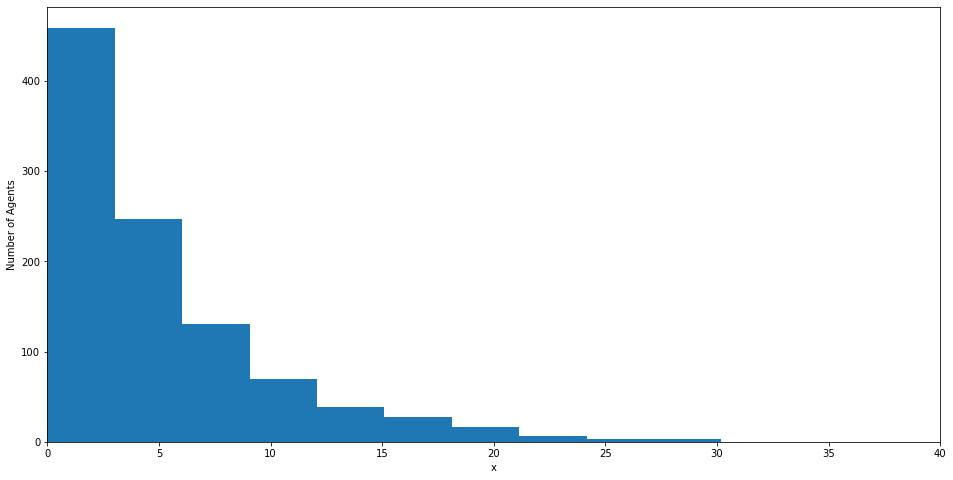

In [5]:
import matplotlib.pyplot as plt

def plot_distribution(values: Population) -> None:
    plt.figure(figsize=(16, 8))
    plt.hist(values)

    plt.xlabel("x")
    plt.xlim(0, 40)
    plt.xticks()

    plt.ylabel("Number of Agents")
    plt.ylim(0, None)
    plt.show()

plot_distribution(fixed_result)

Not quite exponential, but it's getting there!

## Percentage Based
The percentage model is similar to the fixed transaction model except now people give up a fixed percentage of their money. The rules are as follows:


$$
X^i_{t + h} = X^i_t + \delta X^j_t
$$

$$
X^j_{t + h} = X^j_t - \delta X^j_t
$$

where $\delta \in (0, 1)$ is a fixed number that is held constant for the whole simulation. The same logic is coded up below.



In [6]:
def fractional_interaction(x1: Individual, x2: Individual) -> Tuple[Individual, Individual]:
    frac = 0.1
    delta = frac * x2
    return x1 + delta, x2 - delta

This particular system leads to the following PDE.


$$

\partial_t f + \partial_x \left[ \frac{x_0 - x}{N} f \right] = 0

$$

Being that this one is linear and a bit simpler, this one can be solved in general, but paired with our constraints for it being a probability distribution causes it not to be solvable analytically. The variance of this function approaches zero, so this distribution will approach a constant.

In [7]:
fractional_results = simulate(initial_population, t, fractional_interaction)

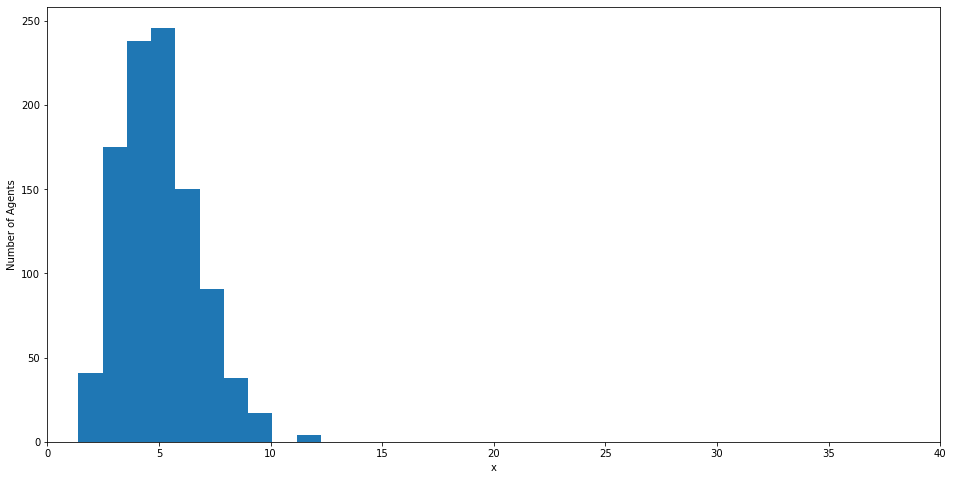

In [8]:
plot_distribution(fractional_results)

## Towards An Average
The percentage model is similar to the fixed transaction model except now people give up a fixed percentage of their money. The rules are as follows:


$$
X^i_{t + h} = (1 - h) X^i_t + \frac{h}{2} (X^i_t + X^j_t)
$$

$$
X^j_{t + h} = (1 - h) X^j_t + \frac{h}{2} (X^i_t + X^j_t)
$$

where $\delta \in (0, 1)$ is a fixed number that is held constant for the whole simulation. The same logic is coded up below with fixed time-step, $h$.

In [9]:
def average_interaction(x1: Individual, x2: Individual) -> Tuple[Individual, Individual]:
    h = 0.1
    avg = (x1 + x2) / 2
    return (1 - h) * x1 + h * avg, (1 - h) * x2 + h * avg

This particular system leads to the following PDE.


$$

\partial_t f + \partial_x \left[ \frac{x - x_0}{N} f \right] = 0

$$

Like the equation above, this can be solved in general but paired with our constraints for it being a probability distribution causes it not to be solvable. But we can compute the variance, and it approaches zero, which means all agents will approach the same value, $x_0$.

In [10]:
from random import gauss
mixed_pop = [x0 + gauss(0, 10) for _ in range(N)]
average_result = simulate(initial_population, t, average_interaction)

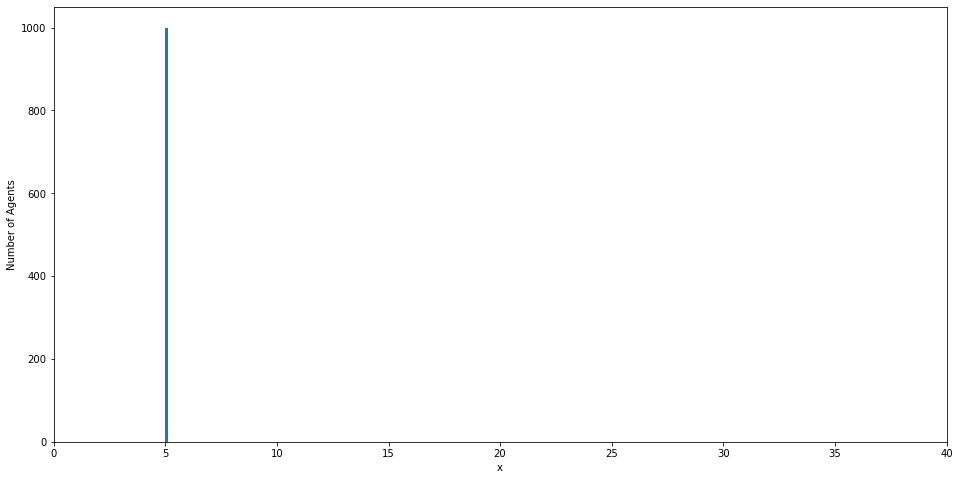

In [11]:
plot_distribution(average_result)